In [ ]:
# Copyright 2023, Acadential, All rights reserved.

# 15-8. RNN, GRU, LSTM을 활용한 NLP 프로젝트

이번 시간에는 RNN, GRU, LSTM에 대한 실습을 진행해보겠습니다. \
이번 실습은 IMDB 데이터셋을 사용하여 영화 리뷰를 긍정과 부정으로 분류하는 모델을 만들어보겠습니다. \
IMDB 데이터셋은 Huggingface에서 제공하는 데이터셋으로, 50,000개의 영화 리뷰가 포함되어 있습니다. \
[Huggingface IMDB 링크] (https://huggingface.co/datasets/imdb)


[Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015) (Maas et al., ACL 2011)

# Install transformers, datasets libraries

이번 실습을 진행하기 위해서는 ```transformers```, ```datasets``` 라이브러리가 필요합니다. 아래 셀을 실행하여 라이브러리를 설치해 주세요.

In [4]:
# Install transformers, datasets libraries
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


# Mount to Google Drive

모델을 학습하기 위해서는 GPU을 사용하는 것을 권장합니다. Google Colab에서 이번 실습을 진행하기 위해서 Colab에 Google Drive을 마운트해줍니다.

In [5]:

from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Lesson/인프런 강의 - 딥러닝 이론 실무 완전 정복/practicals/section_15/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load IMDB Dataset

Huggingface의 ```datasets```을 사용하여 IMDB 데이터셋을 로드해줍니다.

In [6]:
from datasets import load_dataset
# PyTorch library을 import합니다.
import torch

dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

데이터셋을 살펴보도록 하겠습니다. \
아래에서 보시다시피 IMDB 데이터셋은 ```train```, ```test```으로 구성되어 있고 ```text```와 ```label``` field을 가집니다.

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [9]:
# Text의 예시 (영화 리뷰 평)
dataset["train"]["text"][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [10]:
# Label의 예시 (영화 리뷰 라벨값: 0은 부정적, 1은 긍정적 리뷰)
dataset["train"]["label"][0]

0

# Huggingface의 Tokenizer
Text 데이터를 전처리하는 과정에서 Tokenizer를 사용합니다. 이번 프로젝트에서는 Bert Base Cased에서 사용한 Tokenizer를 사용하겠습니다.

Tokenization이란 텍스트를 일정한 기준으로 나누는 방법입니다. Tokenization을 거치면 일정한 기준으로 나눠진 텍스트를 Token이라고 합니다. Token화된 텍스트를 integer 값으로 변환해주어 Embedding으로 mapping할 수 있습니다.

In [11]:
# Huggingface의 AutoTokenizer로 Bert Base Cased tokenizer을 불러옵니다.
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [12]:
# Tokenization을 진행합니다. Tokenization에서 지정되어있는 max_length인 512 이상의 sequence은
# Truncation되도록 설정합니다. 그리고 max_length 이하인 sequence들은 padding을 진행합니다.

dataset = dataset.map(lambda examples: tokenizer(examples["text"],
                                                 truncation=True,
                                                 padding="max_length"),
                      batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [13]:
# Dataset에서 각 데이터 샘플들이 torch 형태로 출력되도록 설정합니다.

dataset.set_format(type='torch',
                   columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])


In [14]:
# input_ids은 text 데이터가 tokenize된 후 각 token들이 integer로 mapping된 것입니다.
# attention_mask은 어떤 token이 padding이 되었는지를 나타내주어 padding이 되지 않은 token들은 1, padding이 된 token들은 0으로 표현됩니다.
# token_type_ids는 문장이 2개 이상일 때, 각 문장을 구분하기 위해 사용됩니다.

dataset["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})

In [15]:
dataset["train"]["text"][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [16]:
dataset["train"]["input_ids"][0]

tensor([  101,   146, 12765,   146,  6586,   140, 19556, 19368, 13329,   118,
          162, 21678,  2162, 17056,  1121,  1139,  1888,  2984,  1272,  1104,
         1155,  1103,  6392,  1115,  4405,  1122,  1165,  1122,  1108,  1148,
         1308,  1107,  2573,   119,   146,  1145,  1767,  1115,  1120,  1148,
         1122,  1108,  7842,  1118,   158,   119,   156,   119, 10148,  1191,
         1122,  1518,  1793,  1106,  3873,  1142,  1583,   117,  3335,  1217,
          170,  5442,  1104,  2441,  1737,   107,  6241,   107,   146,  1541,
         1125,  1106,  1267,  1142,  1111,  1991,   119,   133,  9304,   120,
          135,   133,  9304,   120,   135,  1109,  4928,  1110,  8663,  1213,
          170,  1685,  3619,  3362,  2377,  1417, 14960,  1150,  3349,  1106,
         3858,  1917,  1131,  1169,  1164,  1297,   119,  1130,  2440,  1131,
         3349,  1106,  2817,  1123,  2209,  1116,  1106,  1543,  1199,  3271,
         1104,  4148,  1113,  1184,  1103,  1903,   156, 11547, 

In [17]:
dataset["train"][0]["label"]

tensor(0)

# LSTM 모델 만들어보기

In [20]:
# 모델을 만들기 위해서 필요한 파라미터들을 정의합니다.
vocab_size = tokenizer.vocab_size  # 28996
embedding_dim = 64  # Embedding vector의 차원
num_layers=3  # LSTM Layer의 개수
hidden_dim = 128  # LSTM Hidden State의 차원


In [21]:
# Embedding Layer을 정의
embedding = torch.nn.Embedding(vocab_size, embedding_dim)

In [22]:
# LSTM 모델을 정의
lstm = torch.nn.LSTM(input_size=embedding_dim,
                     hidden_size=hidden_dim,
                     num_layers=num_layers,
                     bidirectional=True,
                     batch_first=True)


In [23]:
# 예시 텐서 생성
batch_size = 8
seq_len = 4
x = torch.rand(batch_size, seq_len, embedding_dim)
# LSTM의 input은 (batch_size, seq_len, embedding_dim)의 shape을 가짐


In [24]:
# LSTM 모델의 출력값
output, (h_n, c_n) = lstm(x)

In [25]:
# Output
# LSTM 모델의 마지막 Layer가 출력하는 Hidden state
output.shape  # (batch_size, seq_len, hidden_dim * num_directions)

torch.Size([8, 4, 256])

In [26]:
# h_n
# LSTM 모델의 각 Layer의 마지막 Hidden state
h_n.shape  # (num_layers * num_directions, batch, hidden_size)

torch.Size([6, 8, 128])

In [27]:
# c_n
# LSTM 모델의 각 Layer의 마지막 Cell state.
c_n.shape  # (num_layers * num_directions, batch, hidden_size)

torch.Size([6, 8, 128])

In [29]:
# FC Layer가 input으로 받아서 최종적으로 Classification에 활용할 feature vector
lstm_feature = torch.sum(h_n, axis=0)
# 각 층의 마지막 hidden state를 모두 더해서 FC Layer의 input으로 사용

lstm_feature.shape

torch.Size([8, 128])

In [31]:
# Classification Layer
num_classes = 2
fc = torch.nn.Linear(128, num_classes)

output = fc(lstm_feature)
output.shape  # (batch_size, num_classes)

torch.Size([8, 2])

# LSTM Model
위에서 각 각 따로 정의된 구성요소들을 하나로 합쳐서 모델로 구성해보도록 하겠습니다.

In [32]:
class Lstm(torch.nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, num_layers, n_class
    ) -> None:
        super(Lstm, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.2,
            bidirectional=True,
            batch_first=True,
        )
        self.fc = torch.nn.Linear(hidden_dim, n_class)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, (h_N, c_N) = self.lstm(x)
        x = torch.sum(h_N, axis=0)
        x = self.fc(x)
        return x

In [33]:
model = Lstm(vocab_size=tokenizer.vocab_size,
             embedding_dim=embedding_dim,
             hidden_dim=hidden_dim,
             num_layers=num_layers,
             n_class=2,
             )

In [34]:
# 샘플 데이터를 만들어보겠습니다.
batch_size= 8
seq_len = 48

# Tokenize된 데이터 샘플의 예시를 만들어보겠습니다.
x = torch.randint(low=0, high=tokenizer.vocab_size, size=(batch_size, seq_len))
# 배열을 구성하는 각 token은 0~vocab_size 사이의 정수입니다.
# Tensor의 크기는 (batch_size, seq_len)입니다.

In [35]:
# Model의 forward pass은 다음과 같습니다.
pred = model(x)

In [36]:
pred.shape  # (batch_size, n_class)으로 정상적으로 출력됩니다.

torch.Size([8, 2])

# DataLoader 정의
앞에서 전처리 (tokenize된) 데이터를 사용해서 DataLoader를 정의합니다.

In [37]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset["train"],
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset["test"],
                              batch_size=32,
                              shuffle=False)


In [38]:
# DataLoader로부터 샘플 데이터를 뽑아봅니다.
sample = next(iter(train_dataloader))

In [39]:
sample.keys()

dict_keys(['label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [40]:
sample["input_ids"].shape  # (batch_size, max_seq_len)으로 구성됩니다.

torch.Size([32, 512])

In [41]:
sample["label"].shape  # (batch_size)으로 구성됩니다.

torch.Size([32])

# Training 및 Validation

In [42]:
from tqdm import tqdm
import os

# Device 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss 함수 정의
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_list = []
test_loss_list = []
test_acc_list = []
train_acc_list = []
max_norm = 5

best_test_acc = 0

for epochs in range(10):
    correct = 0

    tbar = tqdm(train_dataloader)
    model.train()
    size = len(train_dataloader.dataset)

    for batch in tbar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        label = batch['label'].to(device)
        pred = model(input_ids)
        loss = loss_fn(pred, label)
        loss.backward()

        # Gradient Clipping (안정적인 LSTM 학습을 위해)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        optimizer.step()
        tbar.set_description(f'loss - {loss.item():.3f}')
        correct += (pred.argmax(1) == label).type(torch.float).sum().item()

        loss_list.append(loss.item())

    correct /= size
    train_acc_list.append(correct)
    tbar = tqdm(test_dataloader)
    model.eval()

    correct = 0
    test_loss = 0
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)

    for batch in tbar:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            label = batch['label'].to(device)
            pred = model(input_ids)
            loss = loss_fn(pred, label)
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
            tbar.set_description(f'loss - {loss.item():.3f}')
            test_loss += loss.item()

    test_loss /= num_batches
    correct /= size

    test_loss_list.append(test_loss)
    test_acc_list.append(correct)
    print(f"test loss   {test_loss}")
    print(f"test acc   {correct}")

    if correct > best_test_acc:
        best_test_acc = correct
        os.makedirs('checkpoints', exist_ok=True)
        torch.save(model.state_dict(), 'checkpoints/best_lstm_model.pt')



loss - 0.531: 100%|██████████| 782/782 [00:17<00:00, 45.84it/s]


test loss   0.6190595564520572
test acc   0.69448


loss - 0.617: 100%|██████████| 782/782 [00:17<00:00, 44.47it/s]


test loss   0.5933651490627653
test acc   0.74944


loss - 1.307: 100%|██████████| 782/782 [00:17<00:00, 45.27it/s]


test loss   0.48733618414348656
test acc   0.78076


loss - 0.833: 100%|██████████| 782/782 [00:17<00:00, 45.32it/s]


test loss   0.4634654884086088
test acc   0.81804


loss - 1.816: 100%|██████████| 782/782 [00:17<00:00, 44.92it/s]


test loss   0.521849858934236
test acc   0.76872


loss - 2.469: 100%|██████████| 782/782 [00:17<00:00, 44.88it/s]


test loss   0.47802297011151185
test acc   0.81384


loss - 2.422: 100%|██████████| 782/782 [00:17<00:00, 45.12it/s]


test loss   0.5310906905114002
test acc   0.80272


loss - 2.023: 100%|██████████| 782/782 [00:17<00:00, 44.91it/s]


test loss   0.5341460827375998
test acc   0.8222


loss - 2.778: 100%|██████████| 782/782 [00:17<00:00, 44.53it/s]


test loss   0.6063593245061386
test acc   0.82064


loss - 1.783: 100%|██████████| 782/782 [00:17<00:00, 45.00it/s]

test loss   0.7270615847585985
test acc   0.81716


In [ ]:
import os 
os.makedirs("figures", exist_ok=True)

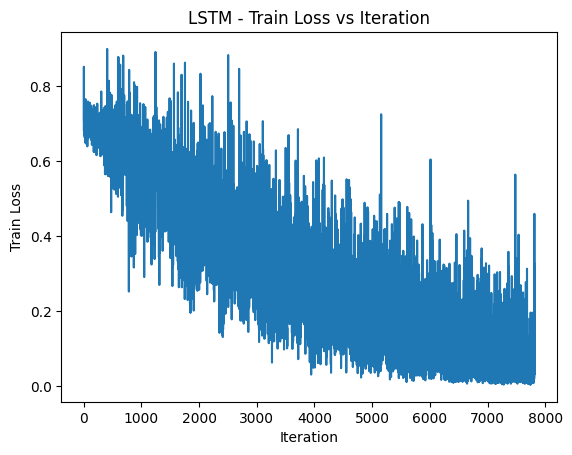

In [43]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel("Train Loss")
plt.title("LSTM - Train Loss vs Iteration")
plt.savefig('figures/lstm_train_loss.png')

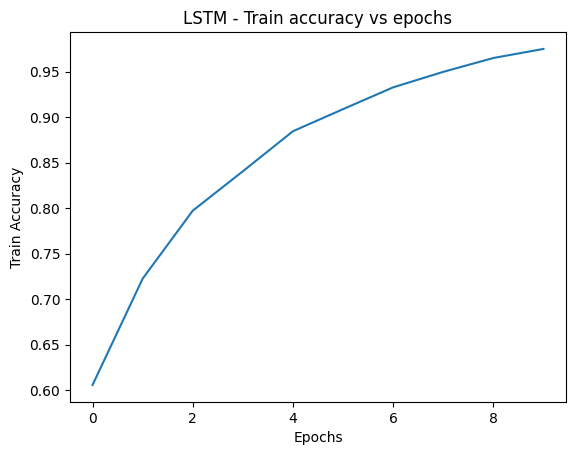

In [44]:
plt.figure()
plt.plot(train_acc_list)
plt.xlabel('Epochs')
plt.ylabel("Train Accuracy")
plt.title("LSTM - Train accuracy vs epochs")
plt.savefig('figures/lstm_train_acc.png')

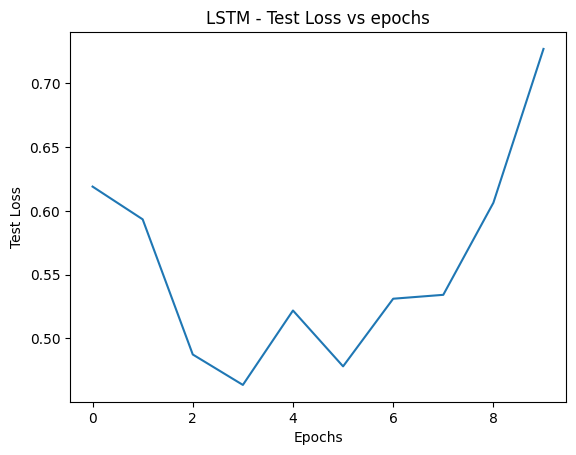

In [45]:
plt.figure()
plt.plot(test_loss_list)
plt.xlabel('Epochs')
plt.ylabel("Test Loss")
plt.title("LSTM - Test Loss vs epochs")
plt.savefig('figures/lstm_test_loss.png')

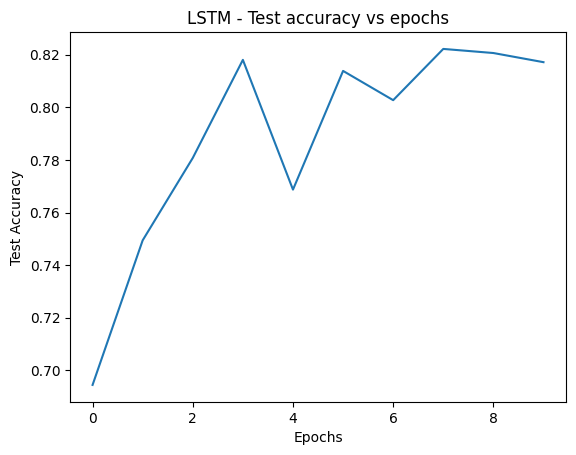

In [46]:
plt.figure()
plt.plot(test_acc_list)
plt.xlabel('Epochs')
plt.ylabel("Test Accuracy")
plt.title("LSTM - Test accuracy vs epochs")
plt.savefig('figures/lstm_test_acc.png')

In [47]:
train_loss_summary = {"lstm": loss_list}
train_acc_summary = {"lstm": train_acc_list}
test_loss_summary = {"lstm": test_loss_list}
test_acc_summary = {"lstm": test_acc_list}

# RNN

In [48]:
from src.train_val import train_loop, val_loop
from src.model import Rnn


In [58]:
model = Rnn(vocab_size=tokenizer.vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            n_class=2)

In [59]:
from tqdm import tqdm

# Device 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss 함수 정의
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_list = []
test_loss_list = []
test_acc_list = []
train_acc_list = []
max_norm = 5

In [60]:
for epoch in range(10):
    train_loss_list, train_acc = train_loop(model,
                                            train_dataloader,
                                            loss_fn,
                                            optimizer)
    test_loss, test_acc = val_loop(model,
                                    test_dataloader,
                                    loss_fn)
    loss_list.extend(train_loss_list)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        os.makedirs('checkpoints', exist_ok=True)
        torch.save(model.state_dict(), 'checkpoints/best_rnn_model.pt')


loss - 1.438: 100%|██████████| 782/782 [00:08<00:00, 88.00it/s]


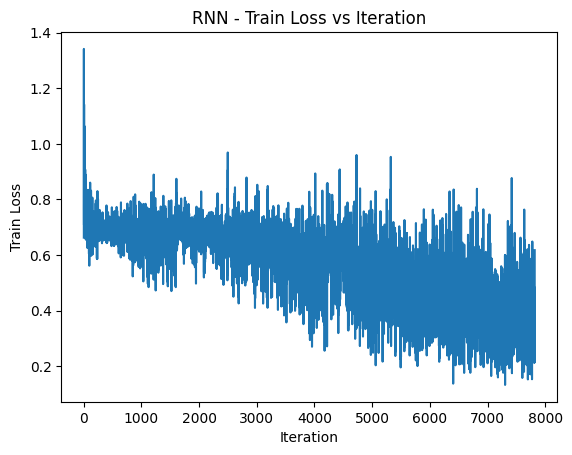

In [61]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel("Train Loss")
plt.title("RNN - Train Loss vs Iteration")
plt.savefig('figures/rnn_train_loss.png')

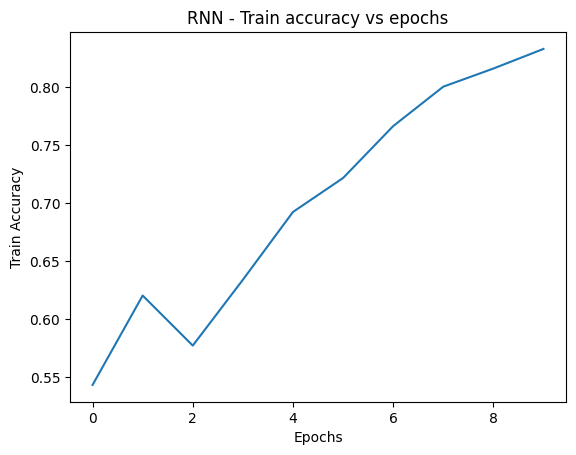

In [62]:
plt.figure()
plt.plot(train_acc_list)
plt.xlabel('Epochs')
plt.ylabel("Train Accuracy")
plt.title("RNN - Train accuracy vs epochs")
plt.savefig('figures/rnn_train_acc.png')

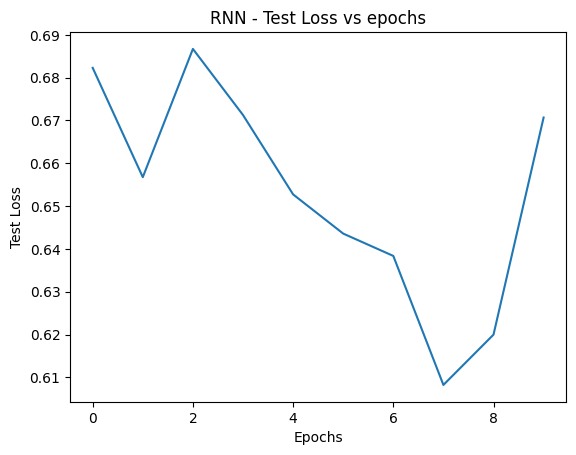

In [63]:
plt.figure()
plt.plot(test_loss_list)
plt.xlabel('Epochs')
plt.ylabel("Test Loss")
plt.title("RNN - Test Loss vs epochs")
plt.savefig('figures/rnn_test_loss.png')

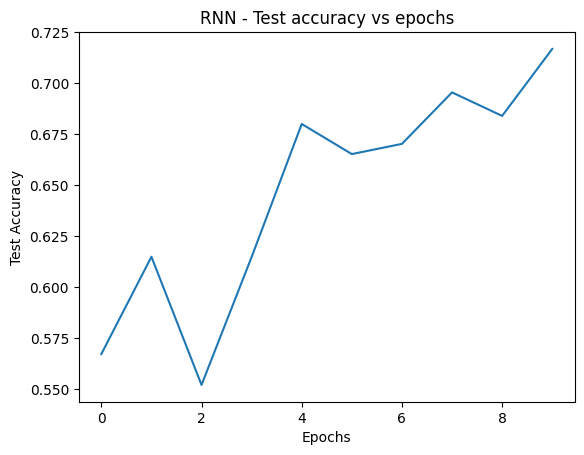

In [64]:
plt.figure()
plt.plot(test_acc_list)
plt.xlabel('Epochs')
plt.ylabel("Test Accuracy")
plt.title("RNN - Test accuracy vs epochs")
plt.savefig('figures/rnn_test_acc.png')

In [65]:
train_loss_summary["rnn"] = loss_list
train_acc_summary["rnn"] = train_acc_list
test_loss_summary["rnn"] = test_loss_list
test_acc_summary["rnn"] = test_acc_list

# GRU

In [66]:
from src.model import Gru


In [67]:
model = Gru(vocab_size=tokenizer.vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            n_class=2)

In [68]:
from tqdm import tqdm

# Device 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss 함수 정의
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_list = []
test_loss_list = []
test_acc_list = []
train_acc_list = []
max_norm = 5

In [69]:
for epoch in range(10):
    train_loss_list, train_acc = train_loop(model,
                                            train_dataloader,
                                            loss_fn,
                                            optimizer)
    test_loss, test_acc = val_loop(model,
                                    test_dataloader,
                                    loss_fn)
    loss_list.extend(train_loss_list)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        os.makedirs('checkpoints', exist_ok=True)
        torch.save(model.state_dict(), 'checkpoints/best_gru_model.pt')


loss - 0.056: 100%|██████████| 782/782 [00:13<00:00, 58.19it/s]


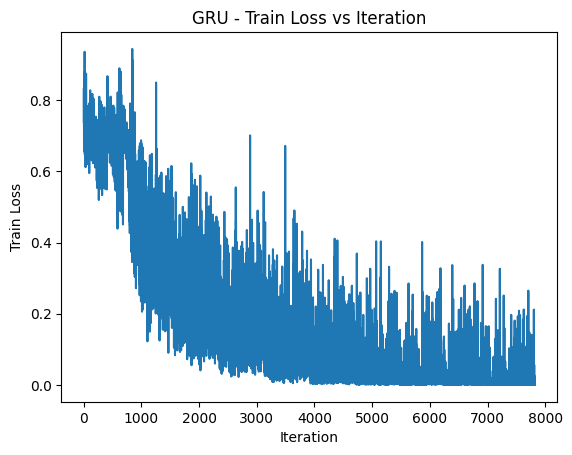

In [70]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel("Train Loss")
plt.title("GRU - Train Loss vs Iteration")
plt.savefig('figures/gru_train_loss.png')

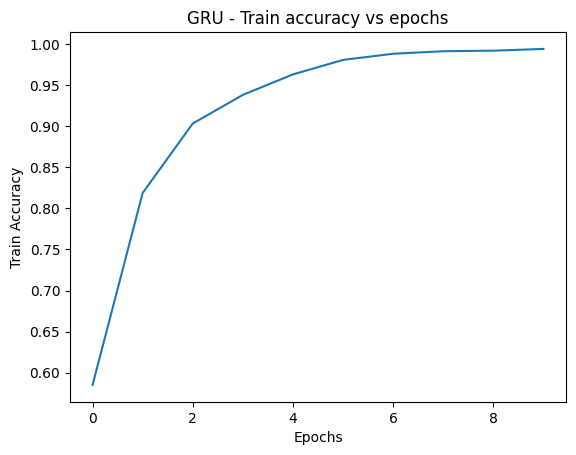

In [71]:
plt.figure()
plt.plot(train_acc_list)
plt.xlabel('Epochs')
plt.ylabel("Train Accuracy")
plt.title("GRU - Train accuracy vs epochs")
plt.savefig('figures/gru_train_acc.png')

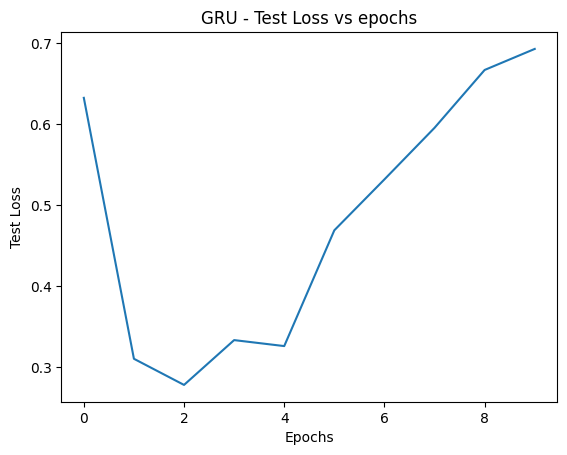

In [72]:
plt.figure()
plt.plot(test_loss_list)
plt.xlabel('Epochs')
plt.ylabel("Test Loss")
plt.title("GRU - Test Loss vs epochs")
plt.savefig('figures/gru_test_loss.png')

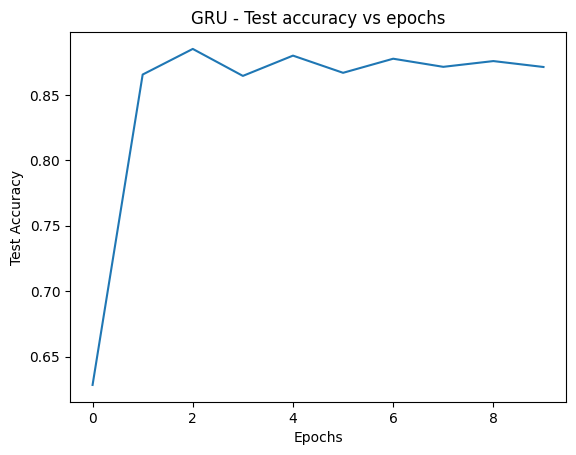

In [73]:
plt.figure()
plt.plot(test_acc_list)
plt.xlabel('Epochs')
plt.ylabel("Test Accuracy")
plt.title("GRU - Test accuracy vs epochs")
plt.savefig('figures/gru_test_acc.png')

In [74]:
train_loss_summary["gru"] = loss_list
train_acc_summary["gru"] = train_acc_list
test_loss_summary["gru"] = test_loss_list
test_acc_summary["gru"] = test_acc_list

In [75]:
import pandas as pd
os.makedirs("results", exist_ok=True)
pd.DataFrame(train_loss_summary).to_csv('results/train_loss_summary.csv')
pd.DataFrame(train_acc_summary).to_csv('results/train_acc_summary.csv')
pd.DataFrame(test_loss_summary).to_csv('results/test_loss_summary.csv')
pd.DataFrame(test_acc_summary).to_csv('results/test_acc_summary.csv')

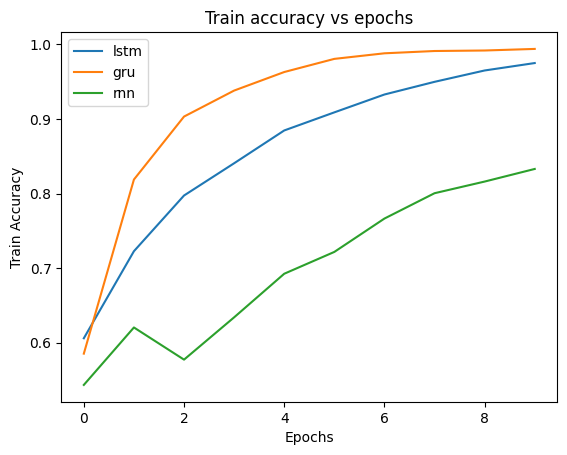

In [77]:
plt.figure()
plt.plot(train_acc_summary["lstm"], label="lstm")
plt.plot(train_acc_summary["gru"], label="gru")
plt.plot(train_acc_summary["rnn"], label="rnn")
plt.xlabel('Epochs')
plt.ylabel("Train Accuracy")
plt.title("Train accuracy vs epochs")
plt.legend()
plt.savefig("figures/train_acc_comparison.png")

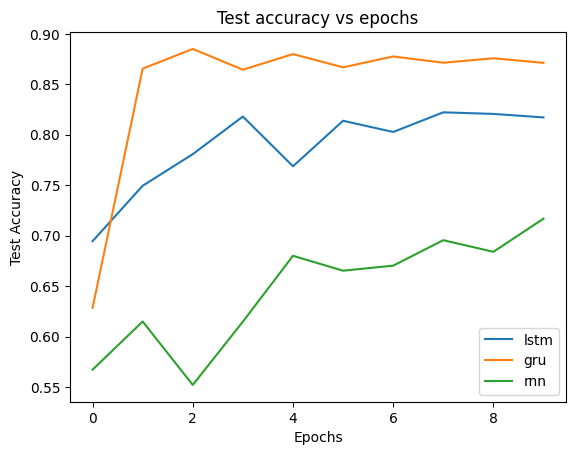

In [78]:
plt.figure()
plt.plot(test_acc_summary["lstm"], label="lstm")
plt.plot(test_acc_summary["gru"], label="gru")
plt.plot(test_acc_summary["rnn"], label="rnn")
plt.xlabel('Epochs')
plt.ylabel("Test Accuracy")
plt.title("Test accuracy vs epochs")
plt.legend()
plt.savefig("figures/test_acc_comparison.png")

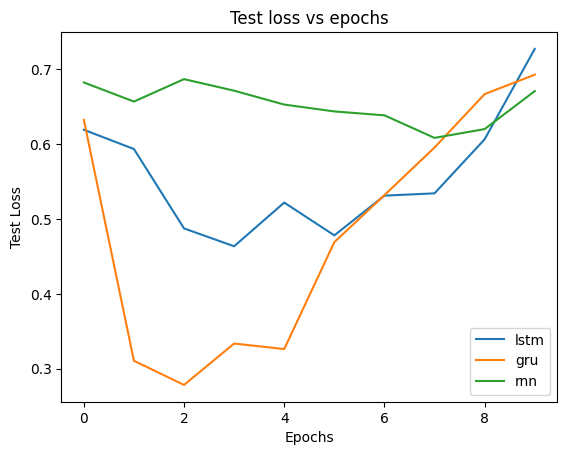

In [79]:
plt.figure()
plt.plot(test_loss_summary["lstm"], label="lstm")
plt.plot(test_loss_summary["gru"], label="gru")
plt.plot(test_loss_summary["rnn"], label="rnn")
plt.xlabel('Epochs')
plt.ylabel("Test Loss")
plt.title("Test loss vs epochs")
plt.legend()
plt.savefig("figures/test_loss_comparison.png")